# 1.introduction

This project is about car classification for [stanford car dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html). The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Here I use transfer learning to speed up the training process. 

# 2.Making a car classifier using Pytorch

## 2.1 mount google drive to colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.2 Copy file from google drive to colab

In [2]:
# # copy dataset from google drive to colab. https://drive.google.com/open?id=1qcSFJ_2Ouom95QYDI3n498JEnqQd71vx
# !cp /content/drive/My\ Drive/20210401/stanford_car_dataset.zip ./

## 2.3 Extract dataset files

In [3]:
# %%time
# # unzip dataset in colab
# !mkdir ./stanford_car_dataset
# !unzip -q stanford_car_dataset.zip -d ./stanford_car_dataset

# 3.Build model

## 3.1 Load packages

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import tqdm
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla P100-PCIE-16GB


## 3.2 Load the data and transform

In [5]:
dataset_dir = "drive/My Drive/20210401/CNN_car/stanford_car_dataset/car_data/car_data/"

# data transformation, you can try different transformation/ data augmentation here
# note: no data augmentation for test data

width, height = 224, 224
train_tfms = transforms.Compose([transforms.Resize((width, height)),
                                 # transforms.RandomHorizontalFlip(),
                                 # transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_tfms = transforms.Compose([transforms.Resize((width, height)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# create datasets
dataset = torchvision.datasets.ImageFolder(root=dataset_dir + "train", transform=train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size=32, shuffle=False, num_workers=2)


## 3.3 Model training function

Train our model, after each epoch, test the model on the test data to see how it's going

In [6]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=5):
    
    losses = []
    accuracies = []
    test_accuracies = []

    # set the model to train mode initially
    model.train()
    for epoch in tqdm.tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):
            #print(data,i)
            # get the inputs and assign them to cuda
            inputs, labels = data
            #print(inputs, labels)
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 / 32 * running_correct / len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

## 3.4 Evaluate on training data
This function is called out after each epoch of training on the training data. We then measure the accuracy of the model.

In [7]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

# 4.Experiment

## 4.1 alexnet

### 4.1.1 define parameters

In [9]:
NUM_CAR_CLASSES = 196
model_ft = models.alexnet(pretrained=True)  # resnet34(pretrained=True)

# for alexnet
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, NUM_CAR_CLASSES)
model_ft = model_ft.to(device)

# uncomment this block for half precision model
"""
model_ft = model_ft.half()


for layer in model_ft.modules():
    if isinstance(layer, nn.BatchNorm2d):
        layer.float()
"""
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

"""
probably not the best metric to track, but we are tracking the training accuracy and measuring whether
it increases by atleast 0.9 per epoch and if it hasn't increased by 0.9 reduce the lr by 0.1x.
However in this model it did not benefit me.
"""
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

### 4.1.2 model training

In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, duration: 2850 s, loss: 5.2867, acc: 0.6005


  3%|▎         | 1/30 [1:35:54<46:21:14, 5754.30s/it]

Accuracy of the network on the test images: 0 %
Epoch 2, duration: 58 s, loss: 5.2743, acc: 0.7230


  7%|▋         | 2/30 [1:37:48<18:57:08, 2436.74s/it]

Accuracy of the network on the test images: 0 %
Epoch 3, duration: 57 s, loss: 5.2547, acc: 0.9191


 10%|█         | 3/30 [1:39:44<10:19:32, 1376.77s/it]

Accuracy of the network on the test images: 0 %
Epoch 4, duration: 59 s, loss: 5.1793, acc: 1.4093


 13%|█▎        | 4/30 [1:41:40<6:21:03, 879.35s/it]  

Accuracy of the network on the test images: 1 %
Epoch 5, duration: 60 s, loss: 5.0023, acc: 2.9534


 17%|█▋        | 5/30 [1:43:38<4:11:58, 604.72s/it]

Accuracy of the network on the test images: 3 %
Epoch 6, duration: 62 s, loss: 4.5455, acc: 6.7525


 20%|██        | 6/30 [1:45:39<2:56:03, 440.16s/it]

Accuracy of the network on the test images: 7 %
Epoch 7, duration: 60 s, loss: 4.0251, acc: 11.8750


 23%|██▎       | 7/30 [1:47:38<2:08:28, 335.14s/it]

Accuracy of the network on the test images: 12 %
Epoch 8, duration: 61 s, loss: 3.4869, acc: 19.5221


 27%|██▋       | 8/30 [1:49:37<1:37:41, 266.42s/it]

Accuracy of the network on the test images: 13 %
Epoch 9, duration: 61 s, loss: 3.1478, acc: 25.6618


 30%|███       | 9/30 [1:51:38<1:17:20, 221.00s/it]

Accuracy of the network on the test images: 16 %
Epoch 10, duration: 62 s, loss: 2.8383, acc: 31.1029


 33%|███▎      | 10/30 [1:53:39<1:03:18, 189.95s/it]

Accuracy of the network on the test images: 19 %
Epoch 11, duration: 62 s, loss: 2.5799, acc: 36.0784


 37%|███▋      | 11/30 [1:55:39<53:26, 168.75s/it]  

Accuracy of the network on the test images: 21 %
Epoch 12, duration: 62 s, loss: 2.4882, acc: 38.6642


 40%|████      | 12/30 [1:57:40<46:13, 154.06s/it]

Accuracy of the network on the test images: 19 %
Epoch 13, duration: 60 s, loss: 1.1652, acc: 68.0882


 43%|████▎     | 13/30 [1:59:39<40:41, 143.61s/it]

Accuracy of the network on the test images: 31 %
Epoch 14, duration: 60 s, loss: 0.6151, acc: 82.3284


 47%|████▋     | 14/30 [2:01:39<36:22, 136.40s/it]

Accuracy of the network on the test images: 33 %
Epoch 15, duration: 63 s, loss: 0.3994, acc: 87.7328


 50%|█████     | 15/30 [2:03:41<33:01, 132.10s/it]

Accuracy of the network on the test images: 33 %
Epoch 16, duration: 63 s, loss: 0.2913, acc: 91.2010


 53%|█████▎    | 16/30 [2:05:45<30:12, 129.46s/it]

Accuracy of the network on the test images: 34 %
Epoch 17, duration: 62 s, loss: 0.2344, acc: 92.6103


 57%|█████▋    | 17/30 [2:07:46<27:29, 126.89s/it]

Accuracy of the network on the test images: 34 %
Epoch 18, duration: 63 s, loss: 0.1578, acc: 95.0000


 60%|██████    | 18/30 [2:09:48<25:07, 125.62s/it]

Accuracy of the network on the test images: 35 %
Epoch 19, duration: 61 s, loss: 0.1553, acc: 95.3064


 63%|██████▎   | 19/30 [2:11:48<22:42, 123.85s/it]

Accuracy of the network on the test images: 35 %
Epoch 20, duration: 61 s, loss: 0.1308, acc: 96.1765


 67%|██████▋   | 20/30 [2:13:48<20:27, 122.74s/it]

Accuracy of the network on the test images: 35 %
Epoch 21, duration: 62 s, loss: 0.1316, acc: 96.0172


 70%|███████   | 21/30 [2:15:50<18:21, 122.40s/it]

Accuracy of the network on the test images: 35 %
Epoch 22, duration: 62 s, loss: 0.1268, acc: 96.0049


 73%|███████▎  | 22/30 [2:17:50<16:15, 121.92s/it]

Accuracy of the network on the test images: 35 %
Epoch 23, duration: 63 s, loss: 0.1268, acc: 96.1765


 77%|███████▋  | 23/30 [2:19:53<14:15, 122.25s/it]

Accuracy of the network on the test images: 35 %
Epoch 24, duration: 62 s, loss: 0.1197, acc: 96.4706


 80%|████████  | 24/30 [2:21:54<12:11, 121.86s/it]

Accuracy of the network on the test images: 35 %
Epoch 25, duration: 64 s, loss: 0.1182, acc: 96.6176


 83%|████████▎ | 25/30 [2:23:57<10:11, 122.20s/it]

Accuracy of the network on the test images: 35 %
Epoch 26, duration: 62 s, loss: 0.1234, acc: 96.1887


 87%|████████▋ | 26/30 [2:25:58<08:06, 121.67s/it]

Accuracy of the network on the test images: 35 %
Epoch 27, duration: 64 s, loss: 0.1219, acc: 96.2990


 90%|█████████ | 27/30 [2:28:00<06:05, 121.92s/it]

Accuracy of the network on the test images: 35 %
Epoch 28, duration: 62 s, loss: 0.1236, acc: 95.8824


 93%|█████████▎| 28/30 [2:30:02<04:03, 121.72s/it]

Accuracy of the network on the test images: 35 %
Epoch 29, duration: 63 s, loss: 0.1237, acc: 96.1887


 97%|█████████▋| 29/30 [2:32:04<02:01, 121.77s/it]

Accuracy of the network on the test images: 35 %
Epoch 30, duration: 63 s, loss: 0.1193, acc: 96.2377


100%|██████████| 30/30 [2:34:05<00:00, 308.19s/it]

Accuracy of the network on the test images: 35 %
Finished Training


### 4.1.3 plot learning curve


Text(0.5, 1.0, 'Test acc')

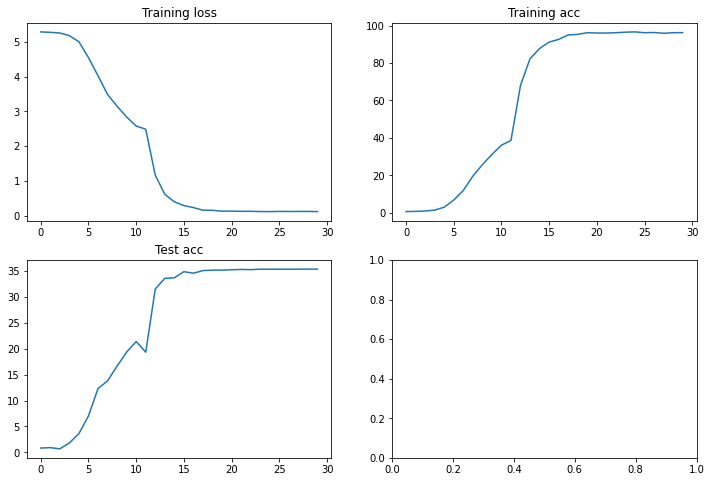

In [ ]:
# plot the stats

f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)
axarr[1, 0].set_title("Test acc")

### 4.1.4 Evaluate the model on single images

In [14]:
# tie the class indices to their names

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir+"train")

In [ ]:
# test the model on random images


# switch the model to evaluation mode to make dropout and batch norm work in eval mode
model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(dataset_dir+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

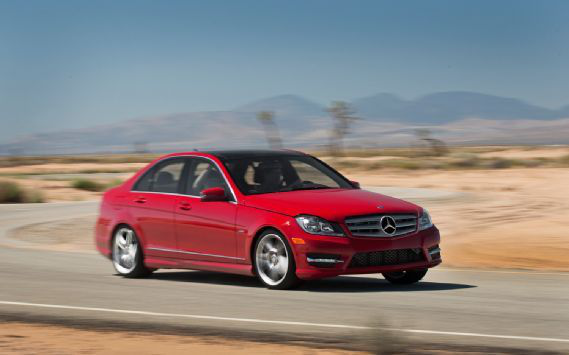

Bentley Continental GT Coupe 2007 confidence:  7.667725563049316


In [ ]:
# get the class name of the prediction
display(Image.open(dataset_dir+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())

## 4.2 resnet34

### 4.2.1 define parameters

In [10]:
model_ft = models.resnet34(pretrained=True)  # resnet34(pretrained=True)

# Freezing model parameters and defining the fully connected network to be attached to the model, 
# loss function and the optimizer.
# We there after put the model on the GPUs
# for param in model_ft.parameters():
#     param.require_grad = False

# replace the last fc layer with an untrained one (requires grad by default)

# for alexnet
# num_ftrs = model_ft.classifier[6].in_features
# model_ft.classifier[6] = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

# for resnet34
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

model_ft = model_ft.to(device)

# uncomment this block for half precision model
"""
model_ft = model_ft.half()


for layer in model_ft.modules():
    if isinstance(layer, nn.BatchNorm2d):
        layer.float()
"""
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

"""
probably not the best metric to track, but we are tracking the training accuracy and measuring whether
it increases by atleast 0.9 per epoch and if it hasn't increased by 0.9 reduce the lr by 0.1x.
However in this model it did not benefit me.
"""
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

### 4.2.2 model training

In [11]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, duration: 962 s, loss: 3.6993, acc: 18.8603


  5%|▌         | 1/20 [31:11<9:52:29, 1871.01s/it]

Accuracy of the network on the test images: 24 %
Epoch 2, duration: 70 s, loss: 1.5189, acc: 58.1740


 10%|█         | 2/20 [33:28<4:15:24, 851.34s/it] 

Accuracy of the network on the test images: 43 %
Epoch 3, duration: 70 s, loss: 0.7189, acc: 78.4926


 15%|█▌        | 3/20 [35:46<2:28:55, 525.64s/it]

Accuracy of the network on the test images: 54 %
Epoch 4, duration: 71 s, loss: 0.3216, acc: 90.9314


 20%|██        | 4/20 [38:05<1:39:29, 373.10s/it]

Accuracy of the network on the test images: 62 %
Epoch 5, duration: 76 s, loss: 0.1429, acc: 96.4706


 25%|██▌       | 5/20 [40:31<1:12:45, 291.06s/it]

Accuracy of the network on the test images: 73 %
Epoch 6, duration: 72 s, loss: 0.0656, acc: 98.4804


 30%|███       | 6/20 [42:53<56:03, 240.27s/it]  

Accuracy of the network on the test images: 74 %
Epoch 7, duration: 73 s, loss: 0.0317, acc: 99.3137


 35%|███▌      | 7/20 [45:17<45:14, 208.81s/it]

Accuracy of the network on the test images: 78 %
Epoch 8, duration: 73 s, loss: 0.0160, acc: 99.5956


 40%|████      | 8/20 [47:40<37:37, 188.10s/it]

Accuracy of the network on the test images: 80 %
Epoch 9, duration: 74 s, loss: 0.0109, acc: 99.6569


 45%|████▌     | 9/20 [50:08<32:11, 175.56s/it]

Accuracy of the network on the test images: 81 %
Epoch 10, duration: 76 s, loss: 0.0098, acc: 99.6569


 50%|█████     | 10/20 [52:37<27:51, 167.11s/it]

Accuracy of the network on the test images: 81 %
Epoch 11, duration: 73 s, loss: 0.0087, acc: 99.6078


 55%|█████▌    | 11/20 [54:58<23:54, 159.36s/it]

Accuracy of the network on the test images: 81 %
Epoch 12, duration: 72 s, loss: 0.0080, acc: 99.6446


 60%|██████    | 12/20 [57:19<20:28, 153.54s/it]

Accuracy of the network on the test images: 81 %
Epoch 13, duration: 73 s, loss: 0.0080, acc: 99.6569


 65%|██████▌   | 13/20 [59:42<17:33, 150.53s/it]

Accuracy of the network on the test images: 81 %
Epoch 14, duration: 76 s, loss: 0.0079, acc: 99.6446


 70%|███████   | 14/20 [1:02:10<14:57, 149.61s/it]

Accuracy of the network on the test images: 81 %
Epoch 15, duration: 74 s, loss: 0.0079, acc: 99.6814


 75%|███████▌  | 15/20 [1:04:38<12:25, 149.10s/it]

Accuracy of the network on the test images: 81 %
Epoch 16, duration: 76 s, loss: 0.0077, acc: 99.6201


 80%|████████  | 16/20 [1:07:06<09:55, 148.77s/it]

Accuracy of the network on the test images: 81 %
Epoch 17, duration: 75 s, loss: 0.0080, acc: 99.6569


 85%|████████▌ | 17/20 [1:09:34<07:25, 148.63s/it]

Accuracy of the network on the test images: 81 %
Epoch 18, duration: 75 s, loss: 0.0079, acc: 99.6324


 90%|█████████ | 18/20 [1:11:58<04:54, 147.35s/it]

Accuracy of the network on the test images: 81 %
Epoch 19, duration: 75 s, loss: 0.0080, acc: 99.6691


 95%|█████████▌| 19/20 [1:14:25<02:27, 147.08s/it]

Accuracy of the network on the test images: 81 %
Epoch 20, duration: 75 s, loss: 0.0076, acc: 99.6814


100%|██████████| 20/20 [1:16:51<00:00, 230.58s/it]

Accuracy of the network on the test images: 81 %
Finished Training


### 4.2.3 plot learning curve


Text(0.5, 1.0, 'Test acc')

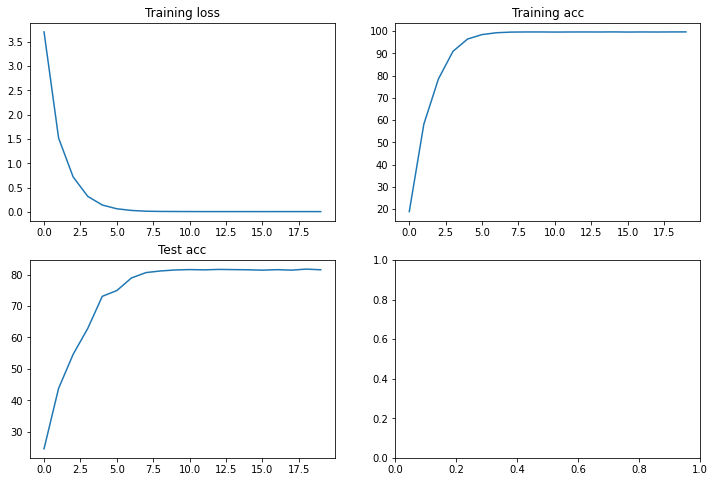

In [12]:
# plot the stats

f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)
axarr[1, 0].set_title("Test acc")

### 4.2.4 evaluate the model on single images

In [15]:
# tie the class indices to their names
classes, c_to_idx = find_classes(dataset_dir+"train")

In [16]:
# test the model on random images


# switch the model to evaluation mode to make dropout and batch norm work in eval mode
model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(dataset_dir+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

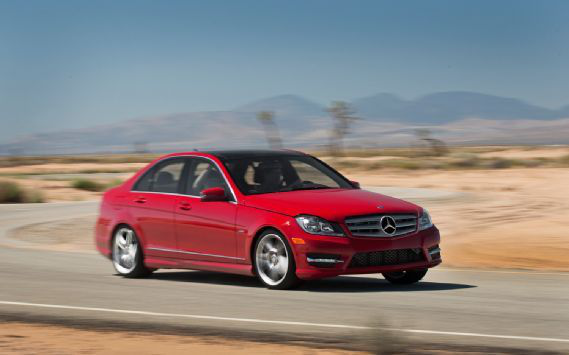

Mercedes-Benz C-Class Sedan 2012 confidence:  5.532705783843994


In [17]:
# get the class name of the prediction
display(Image.open(dataset_dir+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())

## 4.3 vgg16

### 4.3.1 define parameters

In [ ]:
model_ft = models.vgg16(pretrained=True)  # resnet34(pretrained=True)

# Freezing model parameters and defining the fully connected network to be attached to the model, 
# loss function and the optimizer.
# We there after put the model on the GPUs
# for param in model_ft.parameters():
#     param.require_grad = False

# replace the last fc layer with an untrained one (requires grad by default)

# for alexnet
# num_ftrs = model_ft.classifier[6].in_features
# model_ft.classifier[6] = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

# for resnet34
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

# for vgg16
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

model_ft = model_ft.to(device)

# uncomment this block for half precision model
"""
model_ft = model_ft.half()


for layer in model_ft.modules():
    if isinstance(layer, nn.BatchNorm2d):
        layer.float()
"""
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

"""
probably not the best metric to track, but we are tracking the training accuracy and measuring whether
it increases by atleast 0.9 per epoch and if it hasn't increased by 0.9 reduce the lr by 0.1x.
However in this model it did not benefit me.
"""
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

### 4.3.2 model training

In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, duration: 68 s, loss: 5.1805, acc: 1.1152


  3%|▎         | 1/30 [02:08<1:02:16, 128.83s/it]

Accuracy of the network on the test images: 3 %
Epoch 2, duration: 70 s, loss: 4.1436, acc: 9.0931


  7%|▋         | 2/30 [04:21<1:01:17, 131.35s/it]

Accuracy of the network on the test images: 13 %
Epoch 3, duration: 71 s, loss: 2.9892, acc: 24.1667


 10%|█         | 3/30 [06:36<59:49, 132.95s/it]  

Accuracy of the network on the test images: 31 %
Epoch 4, duration: 72 s, loss: 2.1901, acc: 41.1275


 13%|█▎        | 4/30 [08:54<58:22, 134.70s/it]

Accuracy of the network on the test images: 48 %
Epoch 5, duration: 71 s, loss: 1.6395, acc: 54.1176


 17%|█▋        | 5/30 [11:09<56:13, 134.93s/it]

Accuracy of the network on the test images: 49 %
Epoch 6, duration: 73 s, loss: 1.2014, acc: 64.9020


 20%|██        | 6/30 [13:26<54:16, 135.69s/it]

Accuracy of the network on the test images: 53 %
Epoch 7, duration: 72 s, loss: 0.9400, acc: 72.6225


 23%|██▎       | 7/30 [15:43<52:07, 135.98s/it]

Accuracy of the network on the test images: 58 %
Epoch 8, duration: 73 s, loss: 0.2715, acc: 91.2868


 27%|██▋       | 8/30 [18:01<50:06, 136.64s/it]

Accuracy of the network on the test images: 74 %
Epoch 9, duration: 71 s, loss: 0.1239, acc: 95.6005


 30%|███       | 9/30 [20:16<47:39, 136.19s/it]

Accuracy of the network on the test images: 75 %
Epoch 10, duration: 72 s, loss: 0.0886, acc: 96.9240


 33%|███▎      | 10/30 [22:32<45:21, 136.08s/it]

Accuracy of the network on the test images: 76 %
Epoch 11, duration: 69 s, loss: 0.0692, acc: 97.5490


 37%|███▋      | 11/30 [24:44<42:43, 134.94s/it]

Accuracy of the network on the test images: 76 %
Epoch 12, duration: 72 s, loss: 0.0542, acc: 98.0760


 40%|████      | 12/30 [27:00<40:31, 135.08s/it]

Accuracy of the network on the test images: 77 %
Epoch 13, duration: 72 s, loss: 0.0443, acc: 98.3333


 43%|████▎     | 13/30 [29:17<38:26, 135.66s/it]

Accuracy of the network on the test images: 77 %
Epoch 14, duration: 71 s, loss: 0.0391, acc: 98.6275


 47%|████▋     | 14/30 [31:32<36:08, 135.55s/it]

Accuracy of the network on the test images: 77 %
Epoch 15, duration: 71 s, loss: 0.0352, acc: 98.7623


 50%|█████     | 15/30 [33:47<33:50, 135.33s/it]

Accuracy of the network on the test images: 77 %
Epoch 16, duration: 72 s, loss: 0.0369, acc: 98.6765


 53%|█████▎    | 16/30 [36:03<31:38, 135.57s/it]

Accuracy of the network on the test images: 77 %
Epoch 17, duration: 71 s, loss: 0.0390, acc: 98.6520


 57%|█████▋    | 17/30 [38:17<29:17, 135.19s/it]

Accuracy of the network on the test images: 77 %
Epoch 18, duration: 70 s, loss: 0.0363, acc: 98.7132


 60%|██████    | 18/30 [40:32<27:02, 135.17s/it]

Accuracy of the network on the test images: 77 %
Epoch 19, duration: 72 s, loss: 0.0350, acc: 98.6765


 63%|██████▎   | 19/30 [42:48<24:48, 135.34s/it]

Accuracy of the network on the test images: 77 %
Epoch 20, duration: 72 s, loss: 0.0353, acc: 98.6152


 67%|██████▋   | 20/30 [45:04<22:34, 135.48s/it]

Accuracy of the network on the test images: 77 %
Epoch 21, duration: 70 s, loss: 0.0357, acc: 98.5784


 70%|███████   | 21/30 [47:18<20:15, 135.04s/it]

Accuracy of the network on the test images: 77 %
Epoch 22, duration: 72 s, loss: 0.0339, acc: 98.7745


 73%|███████▎  | 22/30 [49:34<18:03, 135.38s/it]

Accuracy of the network on the test images: 77 %
Epoch 23, duration: 74 s, loss: 0.0386, acc: 98.5172


 77%|███████▋  | 23/30 [51:53<15:56, 136.59s/it]

Accuracy of the network on the test images: 77 %
Epoch 24, duration: 72 s, loss: 0.0336, acc: 98.6642


 80%|████████  | 24/30 [54:10<13:39, 136.55s/it]

Accuracy of the network on the test images: 77 %
Epoch 25, duration: 71 s, loss: 0.0326, acc: 98.7255


 83%|████████▎ | 25/30 [56:24<11:18, 135.71s/it]

Accuracy of the network on the test images: 77 %
Epoch 26, duration: 72 s, loss: 0.0333, acc: 98.8113


 87%|████████▋ | 26/30 [58:40<09:03, 135.85s/it]

Accuracy of the network on the test images: 77 %
Epoch 27, duration: 70 s, loss: 0.0354, acc: 98.7377


 90%|█████████ | 27/30 [1:00:54<06:46, 135.51s/it]

Accuracy of the network on the test images: 77 %
Epoch 28, duration: 72 s, loss: 0.0337, acc: 98.7745


 93%|█████████▎| 28/30 [1:03:10<04:31, 135.58s/it]

Accuracy of the network on the test images: 77 %
Epoch 29, duration: 71 s, loss: 0.0349, acc: 98.7132


 97%|█████████▋| 29/30 [1:05:25<02:15, 135.44s/it]

Accuracy of the network on the test images: 77 %
Epoch 30, duration: 71 s, loss: 0.0310, acc: 98.9706


100%|██████████| 30/30 [1:07:41<00:00, 135.38s/it]

Accuracy of the network on the test images: 77 %
Finished Training


### 4.3.3 plot learning curve


Text(0.5, 1.0, 'Test acc')

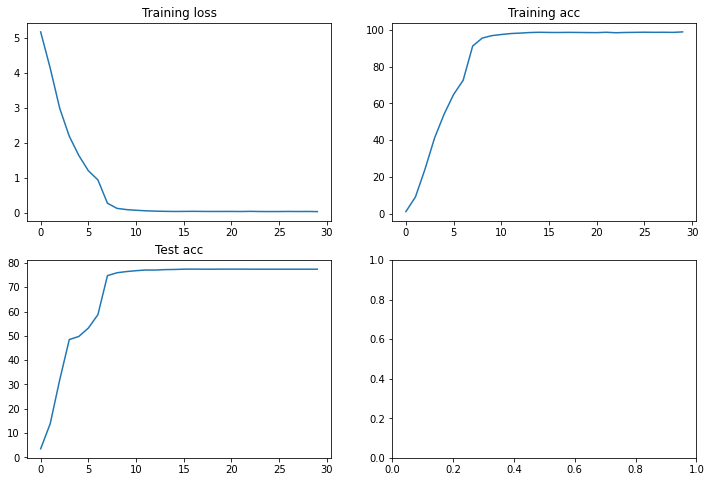

In [ ]:
# plot the stats

f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)
axarr[1, 0].set_title("Test acc")

### 4.3.4 evaluate the model on single images

Next we can use the model on our own images. For that we need to tie the class numbers for which the model returns probablities with the names of those classes.


In [ ]:
# tie the class indices to their names

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir+"train")

In [ ]:
# test the model on random images


# switch the model to evaluation mode to make dropout and batch norm work in eval mode
model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(dataset_dir+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

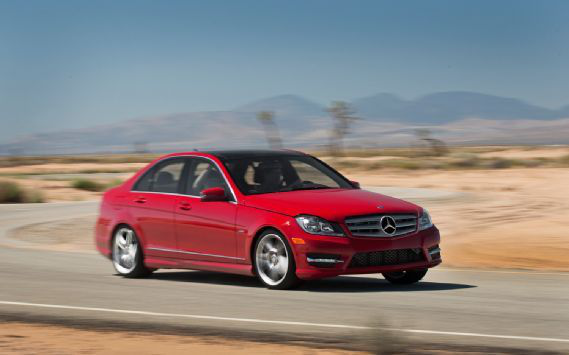

Mercedes-Benz E-Class Sedan 2012 confidence:  9.166444778442383


In [ ]:
# get the class name of the prediction
display(Image.open(dataset_dir+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())

# 5.Save and load model

In [ ]:
PATH = 'car_model.pth'
torch.save(model_ft.state_dict(), PATH)

In [ ]:
model_loaded = torch.load(PATH)
#model_loaded

#python server api

OrderedDict([('features.0.weight',
              tensor([[[[-5.9158e-01,  1.2197e-01,  5.1646e-01],
                        [-6.1154e-01,  3.5311e-01,  7.6967e-01],
                        [-6.8787e-01, -3.4575e-02,  5.0213e-01]],
              
                       [[ 1.7546e-01,  4.7444e-03, -8.7069e-02],
                        [ 5.2257e-02, -7.0204e-02, -2.6870e-01],
                        [ 1.6646e-01, -1.5564e-01, -1.2133e-01]],
              
                       [[ 3.2458e-01, -1.5918e-01, -4.2380e-01],
                        [ 4.9026e-01, -7.1932e-02, -4.8812e-01],
                        [ 6.6635e-01,  4.3066e-02, -2.6224e-01]]],
              
              
                      [[[ 2.4756e-01,  1.1475e-01,  1.5690e-01],
                        [-4.3832e-01, -2.7012e-01,  2.1887e-01],
                        [-2.4759e-01,  1.4977e-01, -2.4647e-02]],
              
                       [[-9.5671e-02, -1.9896e-01,  1.4929e-01],
                        [-8.1527e-01, -3

# 5. Conclusion： 

1. alexnet 90% accuracy on training images in epoch15,  accuracy on test images: 35 %, totally wrong prediction on the single image
2. resnet34 90% accuracy on training images in epoch3,  accuracy on test images: 81 %, correct prediction on the car brand and car model
3. vgg16 90% accuracy on training images in epoch8,  accuracy on test images: 77 %, correct prediction on the car brand, not car model

We can see in trainsfer learning model, resnet34 has the best performance in traning speed and test image accuracy
